# Analyzing reuse of posters

## Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import unquote
import re
import os
import json

## Import posters metadata data

In [59]:
df_zenodo = pd.read_csv("inputs/dataset/derivative/poster-metadata/zenodo.csv")
df_figshare = pd.read_csv("inputs/dataset/derivative/poster-metadata/figshare.csv")
expected_cols = set(df_zenodo.columns)
if set(df_figshare.columns) != expected_cols:
    raise ValueError("Schema mismatch between Zenodo and Figshare CSVs")
df = pd.concat([df_zenodo, df_figshare], ignore_index=True)
df = finalize_df(df)
print(f"Imported data from {len(df)} posters")
df.head(5)

Imported data from 39132 posters


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,references_with_identifiers_count,has_title,has_version,has_description,description_number_words,description_number_characters,files,views,downloads,repository
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,0,True,False,True,348,1929,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,0,True,False,True,116,671,17_Poster.pdf,72,149,Zenodo
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,0,True,False,True,226,1313,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,0,True,False,True,143,778,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,0,True,False,True,115,647,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo


## Helper functions for citation count

In [7]:
def finalize_df(df):
    
    bool_cols = [c for c in df.columns if c.startswith("has_") or c.startswith("is_")]
    count_cols = [c for c in df.columns if c.endswith("_count")]
    float_cols = [c for c in df.columns if c.endswith("_percentage")]
    str_cols = [
        "doi", "doi_url", "repository_url", "license_name",
        "creation_date", "other_dates", "files", "repository"
    ]

    # Ensure columns exist
    for c in str_cols + bool_cols + count_cols + float_cols:
        if c not in df.columns:
            df[c] = pd.NA

    df[bool_cols] = df[bool_cols].astype("boolean")
    df[count_cols] = df[count_cols].astype("Int64")
    df[float_cols] = df[float_cols].astype("Float64")
    df[str_cols] = df[str_cols].astype("string")

    # views/downloads int
    for c in ["views", "downloads"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64")

    return df

In [8]:
_DOI_PATTERN = re.compile(
    r"""
    (?P<doi>                                  # capture group "doi"
        10\.\d{4,9}                           # directory indicator: 10.<4-9 digits>
        /                                     # slash
        [^\s"'<>\]]+                          # suffix: anything except whitespace/quotes/brackets
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)

# Normalize dois, makes it easier to deduplicate citations
def _norm_doi(s):
    
    if not isinstance(s, str):
        return ""

    # Strip whitespace and decode any %-escapes first (handles %2F etc.)
    s_clean = unquote(s.strip())
    if not s_clean:
        return ""

    # Work in lowercase for stable matching
    s_lower = s_clean.lower()
    
    # Search for a DOI substring anywhere in the string
    m = _DOI_PATTERN.search(s_lower)
    if not m:
        return ""

    doi = m.group("doi").strip()

    return doi

# Get normalized doi url
def _norm_doi_url(s):
    doi_id = _norm_doi(s)
    if not doi_id:
        return ""
    return f"https://doi.org/{doi_id}"

#get OA record given DOI:
def get_oa_record(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    work_lookup = f"https://api.openalex.org/works/{_norm_doi_url(target_doi)}"
    if email:
        work_lookup += f"?mailto={email}"
    r = requests.get(work_lookup, timeout=60)
    r.raise_for_status()   # raise on ANY HTTP error

    record = r.json()
    return record


# Get citations given an OA id
def get_all_citing_works_oa(openalex_id, email=None):
    results = []
    cursor = "*"

    while True:
        url = f"https://api.openalex.org/works?filter=cites:{openalex_id}&per-page=200&cursor={cursor}"
        if email:
            url += f"&mailto={email}"

        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
        except requests.Timeout:
            raise

        data = r.json()
        results.extend(data["results"])

        cursor = data["meta"]["next_cursor"]
        if not cursor:
            break

    return results

# Get OA citations given a DOI
def find_citations_oa(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")

    record = get_oa_record(doi, email, api_key)

    try:
        openalex_id_url = record["id"]
        cited_by_count = record["cited_by_count"]
    except KeyError as e:
        raise KeyError(f"Missing expected OpenAlex field: {e}") from e

    if not cited_by_count:
        return []  # no citations

    if not isinstance(openalex_id_url, str) or "/" not in openalex_id_url:
        raise ValueError(f"Malformed OpenAlex id: {openalex_id_url}")

    openalex_id = openalex_id_url.rsplit("/", 1)[-1]

    # Get all citing works
    citing_records = get_all_citing_works_oa(openalex_id, email=email)

    results = []
    for c in citing_records:
        doi_raw = c.get("doi") or ""
        citation_link = _norm_doi_url(doi_raw) or c.get("id", "")

        citation_date_raw = c.get("publication_date") or ""
        try:
            citation_year = int(citation_date_raw[:4]) if citation_date_raw else ""       
        except (ValueError, TypeError):
            citation_year = ""

        if citation_link:
            rec = {
                "poster_doi": doi,
                "source": ["openalex"],
                "citation_link": citation_link,
            }
            if citation_year:
                rec["citation_year"] = citation_year
            results.append(rec)

    return results

# Get DataCite record for a doi
def get_datacite_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    url = f"https://api.datacite.org/dois/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()
    return record
    
# Get citation list from Datacite
def find_citations_datacite(doi, timeout = 30):    
    record  = get_datacite_record(doi, timeout)
    citations = (
    record.get("data", {})
          .get("relationships", {})
          .get("citations", {})
          .get("data", [])
    )
    
    results = []
    for item in citations:
        citation_id = item["id"]
        citation_link = _norm_doi_url(citation_id) or citation_id
        rec = {
            "poster_doi": doi,
            "source": ["datacite"],
            "citation_link": citation_link,
        }
        results.append(rec)
    
    return results

def get_crossref_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")    
    url = f"https://api.crossref.org/works/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()   
    return record

# Get publication year
def get_publication_year(doi, email = None, api_key = None):
    
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}") 
        
    # Try OA first
    try:
        record = get_oa_record(target_doi, email=email, api_key=api_key)
        pub_date = record.get("publication_date")
        if pub_date and len(pub_date) >= 4:
            return int(pub_date[:4])
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Then try CrossRef
    try:
        record = get_crossref_record(target_doi)
        year = record["data"]["attributes"].get("publicationYear")
        if year:
            return int(year)
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Finally try DataCite
    try:
        record = get_datacite_record(target_doi)
        year = record_cf["message"]["created"]["date-parts"][0][0]
        if year:
            return int(year)
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    
    return ""

def find_citations(doi, email=None, api_key=None):
        
    # 1) OA 
    try:
        results_oa = find_citations_oa(doi, email, api_key)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_oa = [] #(404 => no OA record => no OA citations)
        else:
            raise  # real OA error

    # 2) DataCite 
    try:
        results_dc = find_citations_datacite(doi)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_dc = [] #(404 => no DC record => no DC citations)
        else:
            raise  # real DC error
            
    # 3) Deduplicate OA results + index for fast deduplication
    results = []
    index = {}

    for rec in results_oa:
        link = rec.get("citation_link")
        key = link

        # keep on first occurrence in case there are duplicated in oa citations list
        if key in index:
            continue
        index[key] = len(results)
        results.append(rec)

    # 4) Add DataCite citations
    for dc in results_dc:
        link = dc.get("citation_link")
        key = link

        if key in index:
            # already exists: then add datacite to "source" list
            i = index[key]
            results[i]["source"] = sorted(set(results[i]["source"]) | {"datacite"}) #makes sure datacite only added once even if the citation is duplicated in the datacite list
            continue

        # new citation from DataCite
        new_rec = {
            "poster_doi": dc.get("poster_doi"),
            "source": ["datacite"],
            "citation_link": link,
        }

        # if it's a DOI, try OA lookup for year
        if _norm_doi(link):
            year = get_publication_year(link, email, api_key)
            if year:
                new_rec["citation_year"] = year

        index[key] = len(results)
        results.append(new_rec)
    
    return results

# load completed DOIs
def _load_done_set(done_path):
    done = set()
    if not os.path.exists(done_path):
        return done
    with open(done_path, "r", encoding="utf-8") as f:
        for line in f:
            d = line.strip()
            if d:
                done.add(d)
    return done

# save completed DOIs
def _append_done(done_path, doi):
    os.makedirs(os.path.dirname(done_path), exist_ok=True)

    with open(done_path, "a", encoding="utf-8") as f:
        f.write(doi + "\n")
        f.flush()
        os.fsync(f.fileno())

# save citation results to file
def _append_ndjson(path, records):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    n = 0
    with open(path, "a", encoding="utf-8") as f:
        for rec in records:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            n += 1
        f.flush()
        os.fsync(f.fileno())
    return n

def run_find_citations_for_df(
    df,
    *,
    doi_col,
    out_ndjson,
    done_path,
    error_ndjson,
    email = None,
    api_key = None,
    normalize_done_key = False,
) -> dict:
    """
    Runs find_citations() for every DOI in df[doi_col], appends all citation records
    to out_ndjson, and records successfully processed DOIs in done_path so you can resume.

    - Skips missing/blank/NaN DOIs.
    - Skips DOIs already in done_path.
    - Logs failures to error_ndjson and continues.
    """
    if doi_col not in df.columns:
        raise KeyError(f"Missing column '{doi_col}' in df")

    done = _load_done_set(done_path)

    total = 0
    skipped_missing = 0
    skipped_done = 0
    succeeded = 0
    failed = 0
    written = 0

    for raw in df["doi"]:
        doi = _norm_doi(raw)
        if not doi:
            skipped_missing += 1
            continue

        done_key = doi   # <-- define it here, always

        if done_key in done:
            skipped_done += 1
            continue

        try:
            records = find_citations(doi, email=email, api_key=api_key) or []
            written += _append_ndjson(out_ndjson, records)
            _append_done(done_path, done_key)
            done.add(done_key)
            succeeded += 1

        except Exception as e:
            failed += 1
            err_rec = {
                "poster_doi": raw,
                "poster_doi_norm": done_key,
                "error_type": type(e).__name__,
                "error": str(e),
            }
            _append_ndjson(error_ndjson, [err_rec])
            
        msg = (
            f"\r{succeeded + failed}/{len(df)} DOIs completed | "
            f"found {written} citations | "
            f"{failed} DOIs failed"
        )
        print(msg, end="", flush=True)
    
    return {
        "total_rows": total,
        "skipped_missing_doi": skipped_missing,
        "skipped_already_done": skipped_done,
        "succeeded_dois": succeeded,
        "failed_dois": failed,
        "citation_records_written": written,
        "out_ndjson": out_ndjson,
        "done_path": done_path,
        "error_ndjson": error_ndjson,
    }

## Collect citation data

### Get citations from OpenAlex and DataCite for posters with DOI

In [69]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
done_path = "outputs/citations/posters-citations.done.txt"
error_ndjson = "outputs/citations/posters-citations.errors.ndjson"

summary = run_find_citations_for_df(
    df,
    doi_col = "doi",
    out_ndjson = out_ndjson,
    done_path = done_path,
    error_ndjson = error_ndjson,
    email = "bpatel@calmi2.org"    
)
display(summary)

34316/39132 DOIs completed | found 17716 citations | 0 DOIs failed

{'total_rows': 0,
 'skipped_missing_doi': 570,
 'skipped_already_done': 4246,
 'succeeded_dois': 34316,
 'failed_dois': 0,
 'citation_records_written': 17716,
 'out_ndjson': 'outputs/citations/posters-citations.ndjson',
 'done_path': 'outputs/citations/posters-citations.done.txt',
 'error_ndjson': 'outputs/citations/posters-citations.errors.ndjson'}

### Add citations count to metadata table

In [60]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
df_cit = pd.read_json(out_ndjson, lines=True)

# Count citations per poster DOI
cit_counts = df_cit.groupby("poster_doi").size()  # Series: index=doi, value=count

# Add citation count column to metadata (0 if no match orno DOI)
df["citations"] = df["doi"].map(cit_counts).fillna(0).astype("Int64")
print(df["citations"].sum())
display(df.head())

30784


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_title,has_version,has_description,description_number_words,description_number_characters,files,views,downloads,repository,citations
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,True,False,True,348,1929,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo,0
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,True,False,True,116,671,17_Poster.pdf,72,149,Zenodo,3
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,True,False,True,226,1313,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo,0
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,True,False,True,143,778,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo,0
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,True,False,True,115,647,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo,0


## Analyze engagement (views, downloads, and citations)

### Data prep

In [61]:
df_open = df.copy()
df_open = df_open[df_open["is_open_access"] == True] #engagement only for open access posters
df_open["total_keywords_count"] = df_open["keywords_freetext_count"].fillna(0) + df_open["keywords_controlled_vocabularies_count"].fillna(0)
df_open["total_references_count"] = df_open["references_no_identifiers_count"].fillna(0) + df_open["references_with_identifiers_count"].fillna(0)
print(len(df_open))
df_open.head()

38735


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_description,description_number_words,description_number_characters,files,views,downloads,repository,citations,total_keywords_count,total_references_count
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,True,348,1929,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo,0,3,0
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,True,116,671,17_Poster.pdf,72,149,Zenodo,3,1,0
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,True,226,1313,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo,0,1,0
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,True,143,778,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo,0,0,0
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,True,115,647,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo,0,0,0


### Citations per year (no yearwise data for views and downloads)

In [62]:
df_cit["citation_year"] = pd.to_numeric(df_cit["citation_year"], errors="coerce").astype("Int64")
citations_per_year = (
    df_cit.dropna(subset=["citation_year"])
      .groupby("citation_year")
      .size()
      .sort_index()
)

citations_per_year

citation_year
1964       1
2000       3
2001       1
2002       1
2003       2
2004       5
2005       6
2006       7
2007       2
2008      11
2009      15
2010      25
2011      46
2012      96
2013     152
2014     298
2015     420
2016     591
2017     767
2018    1174
2019    1525
2020    2046
2021    2574
2022    1766
2023    2019
2024    2312
2025    1819
dtype: int64

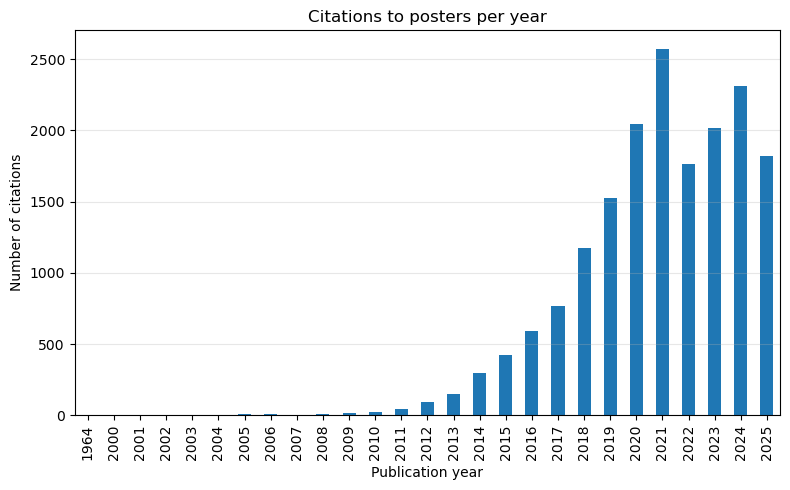

In [63]:
plt.figure(figsize=(8, 5))
citations_per_year.plot(kind="bar")

plt.xlabel("Publication year")
plt.ylabel("Number of citations")
plt.title("Citations to posters per year")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Distribution table

In [64]:
def summarize_distribution(df, col):
    return pd.Series({
        "posters": df[col].count(),
        "count": df[col].sum(),
        "mean": df[col].mean(),
        "median": df[col].median(),
        "std": df[col].std(),
        "min": df[col].min(),
        "p25": df[col].quantile(0.25),
        "p75": df[col].quantile(0.75),
        "p90": df[col].quantile(0.90),
        "p95": df[col].quantile(0.95),
        "max": df[col].max(),
    })

def top_share(df, col, top_pct):
    total = df[col].sum()
    cutoff = df[col].quantile(1 - top_pct)
    return df.loc[df[col] >= cutoff, col].sum() / total

summary = pd.DataFrame({
    "views": summarize_distribution(df_open, "views"),
    "downloads": summarize_distribution(df_open, "downloads"),
    "citations": summarize_distribution(df_open, "citations"),
})

# Add concentration rows
for pct in [0.01, 0.05, 0.10]:
    label = f"top_{int(pct*100)}%_share"
    summary.loc[label, "views"] = top_share(df_open, "views", pct) * 100
    summary.loc[label, "downloads"] = top_share(df_open, "downloads", pct) * 100
    summary.loc[label, "citations"] = top_share(df_open, "citations", pct) * 100

# Round everything
summary_int = summary.round(0).astype(int)

print(summary_int)

                 views  downloads  citations
posters          38735      38735      38735
count          9099220    4143501      30721
mean               235        107          1
median              85         52          0
std                901        236         51
min                  0          0          0
p25                 41         23          0
p75                218        113          0
p90                588        261          0
p95                880        398          1
max             132859      18508       5777
top_1%_share        18         14         92
top_5%_share        39         33        100
top_10%_share       54         48        100


#### Distribution plots

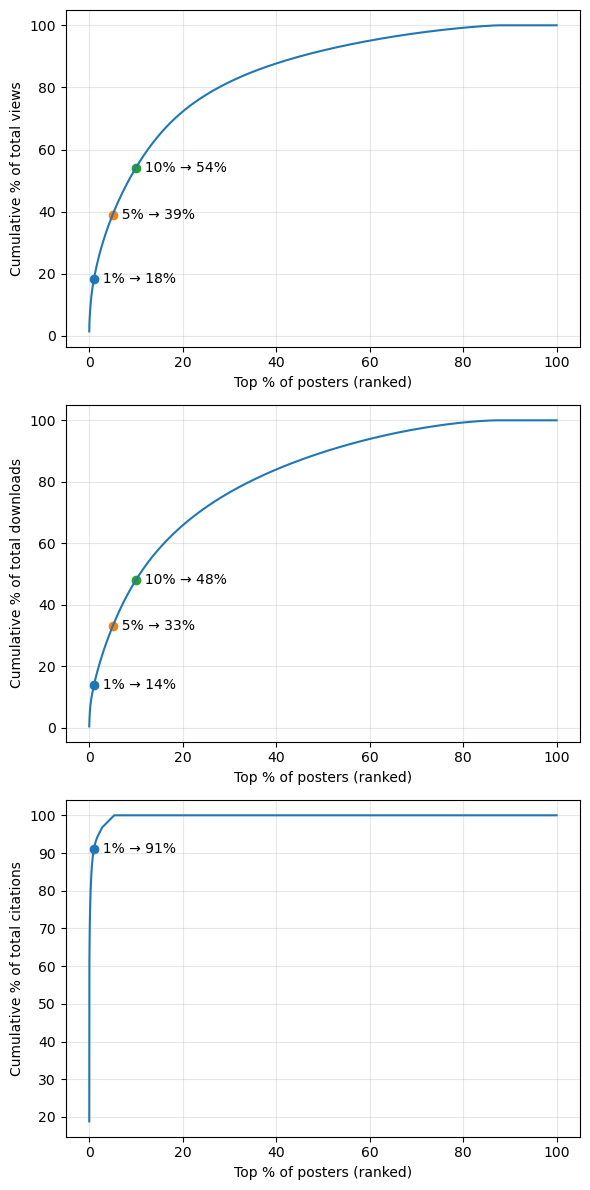

In [65]:
def annotate_top_points(ax, df, col, points=(1, 5, 10)):
    # data
    x = df[col].fillna(0).clip(lower=0).to_numpy()
    x_sorted = np.sort(x)[::-1]

    # handle all-zeros to avoid dividing by zero
    total = x_sorted.sum()
    if total <= 0:
        ax.text(0.5, 0.5, "No data (sum = 0)", ha="center", va="center", transform=ax.transAxes)
        ax.set_xlabel("Top % of posters")
        ax.set_ylabel("Cumulative %")
        ax.grid(True, alpha=0.3)
        return

    cum_share = np.cumsum(x_sorted) / total
    top_pct = np.arange(1, len(x_sorted) + 1) / len(x_sorted)

    # plot
    ax.plot(top_pct * 100, cum_share * 100)
    for p in points:
        idx = int(np.ceil(len(x_sorted) * (p / 100))) - 1
        idx = max(0, min(idx, len(x_sorted) - 1))
        ax.scatter([p], [cum_share[idx] * 100])
        ax.text(p, cum_share[idx] * 100, f"  {p}% → {cum_share[idx]*100:.0f}%", va="center")

    ax.set_xlabel("Top % of posters (ranked)")
    ax.set_ylabel(f"Cumulative % of total {col}")
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharey=False)

annotate_top_points(axes[0], df_open, "views", points=(1, 5, 10))
annotate_top_points(axes[1], df_open, "downloads", points=(1, 5, 10))
annotate_top_points(axes[2], df_open, "citations", points=(1,))

plt.tight_layout()
plt.savefig('outputs/poster-reuse/distribution-engagement.png') 
plt.show()

## Correlation metadata - engagement metrics

38735